# Sorting Robot with a Twist
## Project Checklist
### Core Tasks
- [x] Create all the necessary classes and methods to create reusable code.
- [x] Create an algorithm to identify and sort objects (e.g., colored cubes) into designated bins based on their color.
- [x] Use the Panda robot manipulator and assume the color of the objects is known.
### For Each Detected Object:
- [x] Compute the picking position (pick) and the placing position (place) based on the object’s color.
- [x] Use inverse kinematics to obtain the robot configurations (q_pick and q_place).

### Control Strategies
- [ ] Implement joint-space trajectory interpolation: move from pick to place positions using interpolated joint trajectories between q_pick and q_place.
- [x] Implement resolved-rate motion control: use Cartesian velocity control to reach pick and place poses smoothly.
### Analysis
- [ ] Plot and compare trajectories for both strategies (joint and Cartesian space).
- [ ] Analyze end-effector path smoothness.
- [ ] Analyze execution time.
- [ ] Analyze sorting accuracy.
### Extra Steps
- [ ] Mock a camera so that the robot has to find the location and color of the spheres based on visual input. (NOT FEASIBLE)
- [ ] Putting cylinders between the berries and the boxes and create vectors of repulsion around these objects, this would make the robot sense the obstacles.
## Aesthetic Modifications
- [ ] Create a matrix of coordinates in the boxes to place the berries in the right position
#### Sensing Approaches
1. [ ] Use OpenCV to process the camera image, using HSV color masking to find the pixel coordinates of each berry. (NOT FEASIBLE)
2. [ ] Use a Convolutional Neural Network (CNN) that takes the raw camera image as direct input and is trained to learn its own policy for “seeing” the berries. (NOT FEASIBLE)

## key observations during the presentation
1. Add some maths to the notebook to state clearly what has been done
2. Remember to add numbers to the slides such that the professor can go back to the slide
3. Keep the slide as minimal as possible, not much text
4. Prepare a backup video for the presentation
5. 

# Introduction
In this notebook, we present our project on developing a sorting robot for berries. The robot is designed to identify and sort different types of berries based on their color, size, and quality using computer vision and machine learning techniques.

=== Starting Berry Sorting Task ===

--- Processing Berry 1/10 ---
Berry position: [-0.11757517  0.56374708  0.31      ]
Moving to drop position: [-0.44  0.65  0.47]
Moving to drop position: [-0.44  0.65  0.47]
✅ Berry 1 sorted successfully!

--- Processing Berry 2/10 ---
Berry position: [-0.10031731  0.62077412  0.31      ]
✅ Berry 1 sorted successfully!

--- Processing Berry 2/10 ---
Berry position: [-0.10031731  0.62077412  0.31      ]
Moving to drop position: [-0.44  0.5   0.47]
Moving to drop position: [-0.44  0.5   0.47]
✅ Berry 2 sorted successfully!
✅ Berry 2 sorted successfully!

--- Processing Berry 3/10 ---
Berry position: [-0.03829742  0.62508236  0.31      ]

--- Processing Berry 3/10 ---
Berry position: [-0.03829742  0.62508236  0.31      ]
Moving to drop position: [-0.44  0.35  0.47]
Moving to drop position: [-0.44  0.35  0.47]
✅ Berry 3 sorted successfully!

--- Processing Berry 4/10 ---
Berry position: [0.17488862 0.67731898 0.31      ]
✅ Berry 3 sorted successfully!



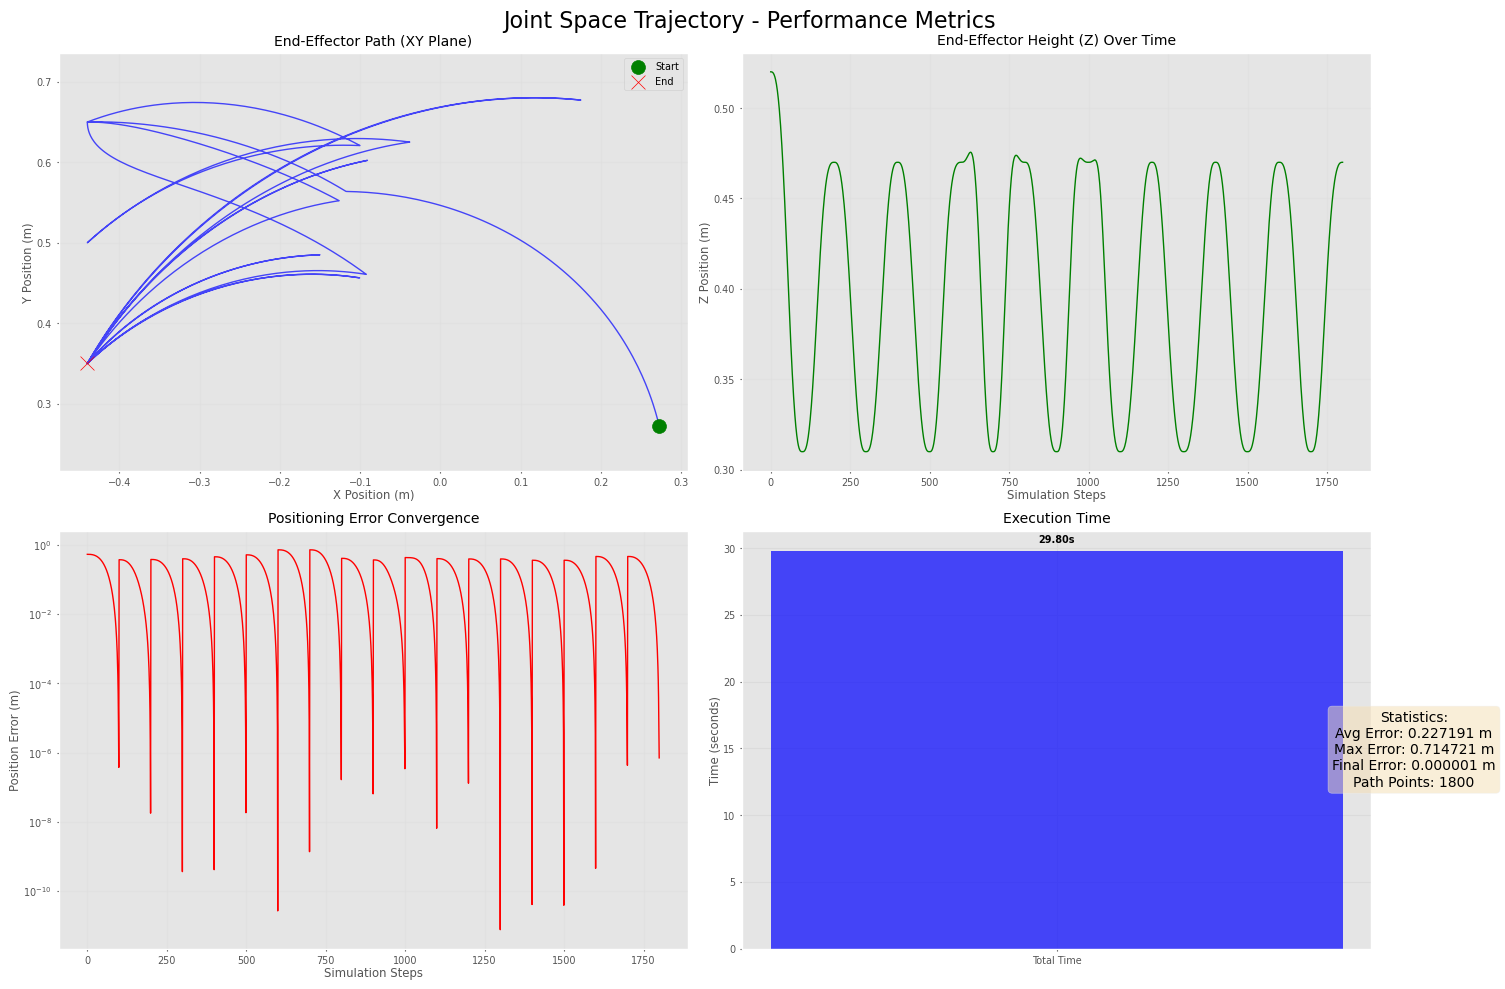


Metrics saved to 'joint_space_metrics.json'


In [3]:
from email import errors
from shutil import move
from matplotlib.pylab import box
import swift
import roboticstoolbox as rtb
import spatialgeometry as sg
import spatialmath as sm
import numpy as np
import time
import matplotlib.pyplot as plt

red = [1, 0, 0]
green = [0, 1, 0]
blue = [0, 0, 1]
orange = [1, 0.5, 0]
colors = [red, green, blue]

light_red = [1, 0.8, 0.8]
light_green = [0.8, 1, 0.8]
light_blue = [0.8, 0.8, 1]


class Berry:
    def __init__(self, radius, table_position_x, table_position_y, table_position_z, table_height, table_depth, table_width):
        self.table_position_z = table_position_z
        self.table_height = table_height
        self.radius = radius
        self.random_color = colors[np.random.choice(len(colors))]
        self.is_picked = False
        
        # Berry positioning - robot is at origin now
        min_x = table_position_x - 0.2
        max_x = table_position_x + 0.2
        min_y = table_position_y - 0.15
        max_y = table_position_y + 0.25
        
        min_x = max(min_x, table_position_x - table_depth/2 + self.radius + 0.1)
        max_x = min(max_x, table_position_x + table_depth/2 - self.radius - 0.1)
        min_y = max(min_y, table_position_y - table_width/2 + self.radius + 0.1)
        max_y = min(max_y, table_position_y + table_width/2 - self.radius - 0.1)
        
        robot_base_pos = np.array([0, 0, 0])  # Robot at origin
        max_attempts = 10
        for attempt in range(max_attempts):
            random_x_position_on_table = np.random.uniform(min_x, max_x)
            random_y_position_on_table = np.random.uniform(min_y, max_y)
            self.std_pose_z = table_position_z + table_height/2 + self.radius
            
            berry_pos = np.array([random_x_position_on_table, random_y_position_on_table, self.std_pose_z])
            distance_from_robot = np.linalg.norm(berry_pos - robot_base_pos)
            
            if distance_from_robot < 0.85:
                break
        else:
            random_x_position_on_table = table_position_x
            random_y_position_on_table = table_position_y + 0.1
            self.std_pose_z = table_position_z + table_height/2 + self.radius
        
        random_position = sm.SE3(random_x_position_on_table, random_y_position_on_table, self.std_pose_z)
        self._sphere = sg.Sphere(radius=radius, pose=random_position, color=self.random_color)
        
    @property
    def pose(self):
        return sm.SE3(self._sphere.T)

    @property
    def swift(self):
        return self._sphere
    
    def set_position(self, x, y, z):
        """Set berry position using simple x, y, z coordinates"""
        self._sphere.T = sm.SE3(x, y, z).A

    def pick_up(self):
        self.is_picked = True

    def drop_at_position(self, position):
        self.is_picked = False
        self.set_position(position.x, position.y, self.std_pose_z - 0.03)

    def get_drop_position_by_color(self, box1_pos, box2_pos, box3_pos):
        if np.array_equal(self.random_color, red):
            return box1_pos
        elif np.array_equal(self.random_color, green):
            return box2_pos
        elif np.array_equal(self.random_color, blue):
            return box3_pos
        else:
            return None

class Box:
    def __init__(self, width, depth, height, position, color=[0.9, 0.9, 0.9], wall_thickness=0.02):
        self.width = width
        self.depth = depth
        self.height = height
        self.position = position
        self.color = color
        self.wall_thickness = wall_thickness
        self.boxes = []
        bottom = sg.Cuboid(scale=[width, depth, wall_thickness],pose=sm.SE3(position.x, position.y, position.z - height/2 + wall_thickness/2), color=color)
        self.boxes.append(bottom)
        front = sg.Cuboid(scale=[width, wall_thickness, height - 2*wall_thickness], pose=sm.SE3(position.x, position.y - depth/2 + wall_thickness/2, position.z),color=color)
        self.boxes.append(front)
        back = sg.Cuboid(scale=[width, wall_thickness, height - 2*wall_thickness], pose=sm.SE3(position.x, position.y + depth/2 - wall_thickness/2, position.z), color=color)
        self.boxes.append(back)
        left = sg.Cuboid(scale=[wall_thickness, depth - 2*wall_thickness, height - 2*wall_thickness],pose=sm.SE3(position.x - width/2 + wall_thickness/2, position.y, position.z),color=color)
        self.boxes.append(left)
        right = sg.Cuboid(scale=[wall_thickness, depth - 2*wall_thickness, height - 2*wall_thickness], pose=sm.SE3(position.x + width/2 - wall_thickness/2, position.y, position.z), color=color)
        self.boxes.append(right)

    @property
    def swift(self):
        return self.boxes
    
class Table:    
    def __init__(self, x, y, z, depth, width, height, color):
        self.x = float(x)
        self.y = float(y)
        self.z = float(z)
        self.depth = float(depth)
        self.width = float(width)
        self.height = float(height) 
        self._cuboid = sg.Cuboid(scale=[self.depth, self.width, self.height], pose=sm.SE3(self.x, self.y, self.z), color=color)
    
    @property
    def table_position_z(self):
        return float(self.z)
    
    @property
    def table_height(self):
        return float(self.height)
    
    @property
    def swift(self):
        return self._cuboid
    
    @swift.setter
    def swift(self, swift):
        self._cuboid = swift

class Cylinder:
    def __init__(self, radius, height, position, color):
        self.radius = radius
        self.height = height
        self.position = position
        self._cylinder = sg.Cylinder(radius=radius, height=height, pose=position, color=color)
    
    @property
    def swift(self):
        return self._cylinder

class Robot:
    def __init__(self):
        # Robot at origin - NO base offset!
        self.dt = 0.01
        self.error = np.ones((3,1))
        self.gain = 1.5
        self.dumping_factor = 0.15
        self.picked_berry = None
        self._panda = rtb.models.Panda()
        # Don't set base - leave it at identity/origin
        self.rest_pose = np.array([np.pi/4, -np.pi/6, 0, -2*np.pi/3, 0, np.pi/2, np.pi/4])
        self._panda.q = self.rest_pose
        
        # Joint limits for smoother motion (tighter than actual limits)
        # Panda joint limits: https://frankaemika.github.io/docs/control_parameters.html
        self.joint_limits_lower = np.array([-2.5, -1.5, -2.5, -2.8, -2.5, 0.0, -2.5])
        self.joint_limits_upper = np.array([2.5, 1.5, 2.5, -0.5, 2.5, 3.5, 2.5])
        
        # Maximum allowed joint change per movement (to prevent wild rotations)
        self.max_joint_change = np.array([1.5, 1.0, 1.5, 1.5, 1.5, 1.5, 1.5])

    @property
    def swift(self):
        return self._panda

    def get_ee_position(self):
        """Get end-effector position - fkine gives us directly usable coordinates"""
        ee_pose = self._panda.fkine(self._panda.q)
        return ee_pose.t
    
    @property
    def end_effector_pose(self):
        """Return end-effector pose"""
        return self._panda.fkine(self._panda.q)
    
    def is_valid_solution(self, q_solution):
        """Check if joint solution is within limits and doesn't require excessive movement"""
        # Check joint limits
        if np.any(q_solution < self.joint_limits_lower) or np.any(q_solution > self.joint_limits_upper):
            return False
        
        # Check for excessive joint movement (prevents 360° rotations)
        joint_change = np.abs(q_solution - self._panda.q)
        if np.any(joint_change > self.max_joint_change):
            return False
        
        return True
    
    def normalize_joint_solution(self, q_solution):
        """Normalize joint angles to be closest to current configuration"""
        q_normalized = q_solution.copy()
        for i in range(len(q_solution)):
            # Find equivalent angle closest to current
            while q_normalized[i] - self._panda.q[i] > np.pi:
                q_normalized[i] -= 2 * np.pi
            while q_normalized[i] - self._panda.q[i] < -np.pi:
                q_normalized[i] += 2 * np.pi
        return q_normalized

    def move_to_target_resolved_rate_of_motion(self, target):
        current_pose = self.end_effector_pose
        self.error = target.t - current_pose.t
        
        J = self._panda.jacob0(self._panda.q)[0:3, :]
        J_damped_pinv = J.T @ np.linalg.inv(J @ J.T + self.dumping_factor * np.eye(3))
        
        q_dot = self.gain * J_damped_pinv @ self.error
        self._panda.qd = q_dot

    def solve_ik_constrained(self, target):
        """Solve IK with constraints - prefer solutions close to current config"""
        # Try IK starting from current configuration (most likely to give nearby solution)
        ik_solution = self._panda.ikine_LM(target, q0=self._panda.q)
        
        if ik_solution.success:
            q_normalized = self.normalize_joint_solution(ik_solution.q)
            if self.is_valid_solution(q_normalized):
                return True, q_normalized
        
        # If that fails, try from rest pose
        ik_solution = self._panda.ikine_LM(target, q0=self.rest_pose)
        if ik_solution.success:
            q_normalized = self.normalize_joint_solution(ik_solution.q)
            if self.is_valid_solution(q_normalized):
                return True, q_normalized
        
        # Last resort: try with random initial guesses
        for _ in range(3):
            q_random = self._panda.q + np.random.uniform(-0.5, 0.5, 7)
            ik_solution = self._panda.ikine_LM(target, q0=q_random)
            if ik_solution.success:
                q_normalized = self.normalize_joint_solution(ik_solution.q)
                if self.is_valid_solution(q_normalized):
                    return True, q_normalized
        
        return False, None

    def move_target_joint_space(self, target, trajectory_time=1.0):
        """Move to target with constrained IK - returns generator with error and position"""
        success, q_target = self.solve_ik_constrained(target)
        
        if not success:
            print(f"Warning: No valid IK solution for target {target.t}")
            return
        
        q_start = self._panda.q.copy()
        
        steps = int(trajectory_time / self.dt)
        trajectory = rtb.jtraj(q_start, q_target, steps)
        
        for i, q in enumerate(trajectory.q):
            self._panda.q = q
            
            current_pose = self.end_effector_pose
            position_error = target.t - current_pose.t
            current_error = np.linalg.norm(position_error)
            
            # Yield error AND current position for path tracking
            yield current_error, current_pose.t

    def pick_berry(self, berry):
        self.picked_berry = berry
        berry.pick_up()
    
    def drop_berry_at(self, drop_position):
        if self.picked_berry:
            self.picked_berry.drop_at_position(drop_position)
            self.picked_berry = None
    
    def update_picked_berry(self):
        """Update berry position to follow the gripper"""
        if self.picked_berry and self.picked_berry.is_picked:
            pos = self.get_ee_position()
            # Place berry closer to the gripper tip (reduced offset)
            self.picked_berry.set_position(pos[0], pos[1], pos[2] - 0.03)
    
    def set_robot_position(self, position):
        self._panda.q = position

    def reset_error(self):
        self.error = np.ones((3,1))

    def has_converged(self, errors_history, threshold=0.001, window=10):
        if len(errors_history) < window:
            return False
        recent_errors = errors_history[-window:]
        error_change = np.abs(recent_errors[-1] - recent_errors[0])
        return error_change < threshold

class Environment:
    def __init__(self):
        self.swift_env = swift.Swift()
        self.swift_env.launch(realtime=True, comms="rtc", browser="notebook")
        self.berries = []

    def add_multiple_objects_swift(self, objects):
        for obj in objects:
            self.swift_env.add(obj)


def joint_space_sorting_task():
    """
    Execute berry sorting task with joint space trajectory control.
    
    Returns:
        tuple: (robot, env, metrics_dict)
            - robot: Robot instance
            - env: Environment instance
            - metrics_dict: Dictionary containing:
                - 'execution_time': Total time in seconds
                - 'path_smoothness': {'x': [...], 'y': [...], 'z': [...]}
                - 'positioning_accuracy': List of errors over time
    """
    
    # Initialize metrics tracking
    metrics = {
        'execution_time': 0.0,
        'path_smoothness': {'x': [], 'y': [], 'z': []},
        'positioning_accuracy': []
    }

    env = Environment()
    table_height = 0.08
    table_width = 0.6
    table_depth = 1
    
    # Position table IN FRONT of robot (robot at origin, table at positive Y)
    table_position_x = 0.0
    table_position_y = 0.5  # In front of robot
    table_position_z = 0.25
    berry_radius = 0.02
    
    box1_position_y = 0.5
    wall_thickness = 0.02
    box1_position_z = table_position_z + table_height + wall_thickness / 2 - 0.01
    box_width = 0.12
    box_depth = 0.12
    box_height = 0.08
    
    table1 = Table(table_position_x, table_position_y, table_position_z, table_depth, table_width, table_height, orange)
    cm_from_table_edge_to_box = table1.depth/2 + box_depth/2 - box_width
    box1_position_x = table_position_x - cm_from_table_edge_to_box
    box_red = Box(box_width, box_depth, box_height, sm.SE3(box1_position_x, box1_position_y - box_width - 0.03, box1_position_z), color=light_red, wall_thickness=wall_thickness)
    box_green = Box(box_width, box_depth, box_height, sm.SE3(box1_position_x, box1_position_y, box1_position_z), color=light_green, wall_thickness=wall_thickness)
    box_blue = Box(box_width, box_depth, box_height, sm.SE3(box1_position_x, box1_position_y + box_width + 0.03, box1_position_z), color=light_blue, wall_thickness=wall_thickness)

    robot = Robot()  # Robot at origin

    env.swift_env.add(robot.swift)
    env.swift_env.add(table1.swift)
    env.add_multiple_objects_swift(box_red.boxes)
    env.add_multiple_objects_swift(box_green.boxes)
    env.add_multiple_objects_swift(box_blue.boxes)
    env.swift_env.step(1)

    # Box centers - use exact same positions as the boxes themselves
    box1_center = sm.SE3(box_red.position.x, box_red.position.y, box_red.position.z + box_height/2)
    box2_center = sm.SE3(box_green.position.x, box_green.position.y, box_green.position.z + box_height/2)
    box3_center = sm.SE3(box_blue.position.x, box_blue.position.y, box_blue.position.z + box_height/2)

    red_center_marker = sg.Sphere(radius=0.01, pose=box1_center, color=red)
    green_center_marker = sg.Sphere(radius=0.01, pose=box2_center, color=green)
    blue_center_marker = sg.Sphere(radius=0.01, pose=box3_center, color=blue)
    total_berries = 10

    for i in range(total_berries):
        berry = Berry(berry_radius, table_position_x, table_position_y, table_position_z, table_height, table_depth, table_width)
        env.swift_env.add(berry.swift)
        env.berries.append(berry)

    def move_to_joint_space(target_pose, carry_berry=False):
        """Joint space movement with orientation handling and constraints"""
        
        orientations_to_try = [
            sm.SO3.RPY(0, np.pi, 0),
            sm.SO3.RPY(0, np.pi*0.9, 0),
            sm.SO3.RPY(np.pi/8, np.pi, 0),
            sm.SO3.RPY(-np.pi/8, np.pi, 0),
        ]
        
        for i, orientation in enumerate(orientations_to_try):
            target_with_orientation = sm.SE3.Rt(orientation, target_pose.t)
            
            # Use constrained IK solver
            success, _ = robot.solve_ik_constrained(target_with_orientation)
            
            if success:
                trajectory_generator = robot.move_target_joint_space(target_with_orientation)
                
                if trajectory_generator is not None:
                    for current_error, current_pos in trajectory_generator:
                        # Track metrics
                        metrics['positioning_accuracy'].append(current_error)
                        metrics['path_smoothness']['x'].append(current_pos[0])
                        metrics['path_smoothness']['y'].append(current_pos[1])
                        metrics['path_smoothness']['z'].append(current_pos[2])
                        
                        if carry_berry:
                            robot.update_picked_berry()
                        env.swift_env.step(robot.dt)
                    
                    robot.reset_error()
                    return True
        
        print(f"❌ Error: Could not reach target {target_pose.t} with any orientation")
        return False

    print("=== Starting Berry Sorting Task ===")
    
    # Start timing
    start_time = time.time()
    
    for i, berry in enumerate(env.berries):
        
        print(f"\n--- Processing Berry {i+1}/{len(env.berries)} ---")
        
        # Phase 1: Move to berry position
        target_pose = berry.pose
        print(f"Berry position: {target_pose.t}")

        if move_to_joint_space(target_pose, carry_berry=False):
            # Phase 2: Pick up berry
            robot.pick_berry(berry)
            robot.update_picked_berry()
            env.swift_env.step(0.2)
            time.sleep(0.1)

            # Phase 3: Move to appropriate box
            drop_center = berry.get_drop_position_by_color(box1_center, box2_center, box3_center)
            move_pose = sm.SE3(drop_center.x, drop_center.y, drop_center.z + 0.1)
            print(f"Moving to drop position: {move_pose.t}")

            if move_to_joint_space(move_pose, carry_berry=True):
                # Phase 4: Drop berry in box
                robot.drop_berry_at(drop_center)
                env.swift_env.step(0.1)
                print(f"✅ Berry {i+1} sorted successfully!")
                
                if berry.random_color == red:
                    env.swift_env.add(red_center_marker)
                elif berry.random_color == green:
                    env.swift_env.add(green_center_marker)
                else:
                    env.swift_env.add(blue_center_marker)

                time.sleep(0.1)
            else:
                print(f"❌ Failed to reach drop position for berry {i+1}")
        else:
            print(f"❌ Failed to reach berry {i+1}")
    
    # End timing
    metrics['execution_time'] = time.time() - start_time
    
    print("\n=== Berry Sorting Task Completed ===")
    print(f"Total Execution Time: {metrics['execution_time']:.2f} seconds")
    print(f"Total Path Points Tracked: {len(metrics['path_smoothness']['x'])}")
    print(f"Final Positioning Error: {metrics['positioning_accuracy'][-1]:.6f} m")
    
    return robot, env, metrics


def plot_metrics(metrics, title="Joint Space Trajectory Metrics"):
    """
    Plot the three key metrics: path smoothness, positioning accuracy, and execution time.
    
    Args:
        metrics (dict): Dictionary containing metrics data
        title (str): Title for the plot
    """
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(title, fontsize=16)
    
    # 1. Path Smoothness - XY Plane
    axs[0, 0].plot(metrics['path_smoothness']['x'], metrics['path_smoothness']['y'], 'b-', alpha=0.7, linewidth=1)
    axs[0, 0].scatter(metrics['path_smoothness']['x'][0], metrics['path_smoothness']['y'][0], 
                      c='green', s=100, marker='o', label='Start', zorder=5)
    axs[0, 0].scatter(metrics['path_smoothness']['x'][-1], metrics['path_smoothness']['y'][-1], 
                      c='red', s=100, marker='x', label='End', zorder=5)
    axs[0, 0].set_title('End-Effector Path (XY Plane)')
    axs[0, 0].set_xlabel('X Position (m)')
    axs[0, 0].set_ylabel('Y Position (m)')
    axs[0, 0].legend()
    axs[0, 0].grid(True, alpha=0.3)
    axs[0, 0].axis('equal')
    
    # 2. Path Smoothness - Z Height over time
    steps = np.arange(len(metrics['path_smoothness']['z']))
    axs[0, 1].plot(steps, metrics['path_smoothness']['z'], 'g-', linewidth=1)
    axs[0, 1].set_title('End-Effector Height (Z) Over Time')
    axs[0, 1].set_xlabel('Simulation Steps')
    axs[0, 1].set_ylabel('Z Position (m)')
    axs[0, 1].grid(True, alpha=0.3)
    
    # 3. Positioning Accuracy - Error over time
    steps = np.arange(len(metrics['positioning_accuracy']))
    axs[1, 0].plot(steps, metrics['positioning_accuracy'], 'r-', linewidth=1)
    axs[1, 0].set_title('Positioning Error Convergence')
    axs[1, 0].set_xlabel('Simulation Steps')
    axs[1, 0].set_ylabel('Position Error (m)')
    axs[1, 0].set_yscale('log')
    axs[1, 0].grid(True, alpha=0.3)
    
    # 4. Execution Time Summary
    axs[1, 1].bar(['Total Time'], [metrics['execution_time']], color='blue', alpha=0.7)
    axs[1, 1].set_title('Execution Time')
    axs[1, 1].set_ylabel('Time (seconds)')
    axs[1, 1].text(0, metrics['execution_time'] + 0.5, 
                   f"{metrics['execution_time']:.2f}s", 
                   ha='center', va='bottom', fontweight='bold')
    
    # Add statistics text
    avg_error = np.mean(metrics['positioning_accuracy'])
    max_error = np.max(metrics['positioning_accuracy'])
    final_error = metrics['positioning_accuracy'][-1]
    
    stats_text = f"Statistics:\n"
    stats_text += f"Avg Error: {avg_error:.6f} m\n"
    stats_text += f"Max Error: {max_error:.6f} m\n"
    stats_text += f"Final Error: {final_error:.6f} m\n"
    stats_text += f"Path Points: {len(metrics['path_smoothness']['x'])}"
    
    axs[1, 1].text(0.5, metrics['execution_time'] * 0.5, stats_text,
                   ha='center', va='center', fontsize=10,
                   bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.tight_layout()
    plt.show()
    
    return fig


if __name__ == "__main__":
    # Run the task and collect metrics
    robot, env, metrics = joint_space_sorting_task()
    
    # Plot the results
    plot_metrics(metrics, title="Joint Space Trajectory - Performance Metrics")
    
    # Optional: Save metrics to file
    import json
    with open('joint_space_metrics.json', 'w') as f:
        # Convert numpy arrays to lists for JSON serialization
        json_metrics = {
            'execution_time': metrics['execution_time'],
            'path_smoothness': {
                'x': [float(v) for v in metrics['path_smoothness']['x']],
                'y': [float(v) for v in metrics['path_smoothness']['y']],
                'z': [float(v) for v in metrics['path_smoothness']['z']]
            },
            'positioning_accuracy': [float(v) for v in metrics['positioning_accuracy']]
        }
        json.dump(json_metrics, f, indent=2)
    print("\nMetrics saved to 'joint_space_metrics.json'")